In [120]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math

### Branch and Bound  

In [121]:
class Node:
    def __init__(self, bound, boundEdges, level, cost, solution):
        self.bound = bound
        self.boundEdges = boundEdges
        self.level = level
        self.cost = cost
        self.solution = solution
    
    def __lt__(self, other):
        return self.bound < other.bound
    
    def __repr__(self) -> str:
        return f"Node({self.bound}, {self.boundEdges}, {self.level}, {self.cost}, {self.solution})"


def findTwoMinimalEdges(list):
    min1 = np.inf
    min2 = np.inf
    for j in list:
        if list[j]['weight'] < min1:
            min2 = min1
            min1 = list[j]['weight']
        elif list[j]['weight'] < min2:
            min2 = list[j]['weight']
    return min1, min2

def findInitialBound(A):
    bound = 0
    initialBoundEdges = np.zeros((A.number_of_nodes(), 2), dtype=list)
    for i in range(A.number_of_nodes()):
        min1, min2 = findTwoMinimalEdges(A[i])
        initialBoundEdges[i][0] = min1
        initialBoundEdges[i][1] = min2
        bound += min1 + min2
    return math.ceil(bound / 2), initialBoundEdges

def findBound(A, solution, boundEdges):
    changedEdges = np.zeros(A.number_of_nodes(), dtype=int)
    newEdges = np.array(boundEdges)
    edgeWeight = A[solution[-2]][solution[-1]]['weight']
    if newEdges[solution[-2]][0] != edgeWeight:
        if changedEdges[solution[-2]] == 0:
            newEdges[solution[-2]][1] = edgeWeight
        else:
            newEdges[solution[-2]][0] = edgeWeight
        changedEdges[solution[-2]] += 1
    if newEdges[solution[-1]][0] != edgeWeight:
        if changedEdges[solution[-1]] == 0:
            newEdges[solution[-1]][1] = edgeWeight
        else:
            newEdges[solution[-1]][0] = edgeWeight
        changedEdges[solution[-1]] += 1
    sum = np.sum(newEdges)
    return math.ceil(sum / 2), newEdges


In [122]:
from heapq import heappush, heappop

def branchAndBoundTSP(A):
    initialBound, initialBoundEdges = findInitialBound(A)
    root = Node(initialBound, initialBoundEdges, 1, 0, [0])
    heap = []
    heappush(heap, root)
    best = np.inf
    solution = []
    while heap:
        node = heappop(heap)
        
        if node.level > A.number_of_nodes():
            if best > node.cost:
                best = node.cost
                solution = node.solution
        else:
            if node.bound < best:
                if node.level < A.number_of_nodes():
                    for k in range(1, A.number_of_nodes()):
                        try:
                            edgeWeight = A[node.solution[-1]][k]['weight']
                        except KeyError:
                            continue
                        newBound, newEdges = findBound(A, node.solution + [k], node.boundEdges) 
                        if k not in node.solution and newBound < best:
                            newNode = Node(newBound, newEdges, node.level + 1, node.cost + edgeWeight, node.solution + [k])
                            if k == 2:
                                if 1 not in node.solution:
                                    continue 
                            heappush(heap, newNode)
                else:
                    newBound, newEdges = findBound(A, node.solution + [0], node.boundEdges)
                    edgeWeight = A[node.solution[-1]][0]['weight']
                    if edgeWeight != 0 and newBound < best:
                        newNode = Node(newBound, newEdges, node.level + 1, node.cost + edgeWeight, node.solution + [0])
                        heappush(heap, newNode)
    return best, solution

### Twice Around The Tree

In [123]:
def findPathWeight(A, path):
    weight = 0
    for i in range(len(path) - 1):
        weight += A[path[i]][path[i + 1]]['weight']
    return weight

def twiceAroundTheTreeTSP(A):
    MST = nx.minimum_spanning_tree(A)
    path = nx.dfs_preorder_nodes(MST, 0)
    path = list(path)
    path.append(path[0])
    weight = findPathWeight(A, path)
    return weight, path

### Christofides

In [124]:
def findShortcutPath(A):
    path = list(nx.eulerian_circuit(A, 0))
    path = [x[0] for x in path]

    # remove duplicates
    shortcutPath = list(dict.fromkeys(path))
    
    return shortcutPath + [shortcutPath[0]]

def christofidesTSP(A):
    MST = nx.minimum_spanning_tree(A)
    degrees = nx.degree(MST)
    oddNodes = [x[0] for x in degrees if degrees[x[0]] % 2 == 1]
    oddNodesSubgraph = nx.subgraph(A, oddNodes)
    matching = list(nx.min_weight_matching(oddNodesSubgraph, maxcardinality=True))

    MSTMultiGraph = nx.MultiGraph(MST)
    for i in range(len(matching)):
        node1 = matching[i][0]
        node2 = matching[i][1]
        MSTMultiGraph.add_edge(node1, node2, weight=A[node1][node2]['weight'])

    path = findShortcutPath(MSTMultiGraph)
    weight = findPathWeight(A, path)

    return weight, path

### Tests

In [125]:
def euclideanDistance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def manhattanDistance(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2)

def generateInstance(n, costFunction):
    graph = nx.complete_graph(n)
    nodes = []
    for i in range(n):
        newX = np.random.randint(1, n)
        newY = np.random.randint(1, n)
        for j in range(len(nodes)):
            if j == i:
                graph[i][j]['weight'] = 0
            else:
                x = nodes[j][0]
                y = nodes[j][1]
                graph[i][j]['weight'] = costFunction(x, y, newX, newY)
                graph[j][i]['weight'] = graph[i][j]['weight']
        nodes.append((newX, newY))
    return graph

def drawGraph(A):
    layout = nx.spring_layout(A)
    nx.draw(A, layout)
    nx.draw_networkx_edge_labels(A, pos=layout, edge_labels=nx.get_edge_attributes(A, 'weight'))
    labels = {i: chr(ord('a') + i) for i in range(len(A))}
    nx.draw_networkx_labels(A, pos=layout, labels=labels)
    plt.show()

### Test 1

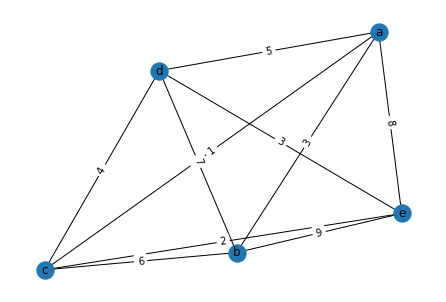

(16, [0, 1, 3, 4, 2, 0])
(16, [0, 2, 4, 3, 1, 0])
(16, [0, 1, 3, 4, 2, 0])


In [126]:
A = [[0, 3, 1, 5, 8],
    [3, 0, 6, 7, 9],
    [1, 6, 0, 4, 2],
    [5, 7, 4, 0, 3],
    [8, 9, 2, 3, 0]]

A = nx.from_numpy_matrix(np.matrix(A), create_using=nx.Graph)

drawGraph(A)

print(branchAndBoundTSP(A))
print(twiceAroundTheTreeTSP(A))
print(christofidesTSP(A))

### Test 2

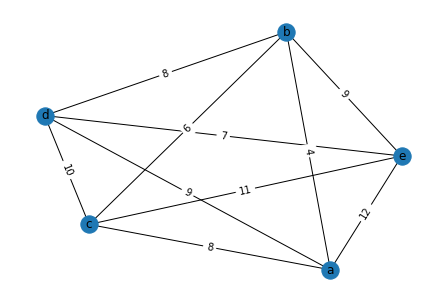

(37, [0, 1, 2, 4, 3, 0])
(39, [0, 1, 2, 3, 4, 0])
(38, [0, 1, 3, 4, 2, 0])


In [127]:
G2 = [[0, 4, 8, 9, 12],
    [4, 0, 6, 8, 9],
    [8, 6, 0, 10, 11],
    [9, 8, 10, 0, 7],   
    [12, 9, 11, 7, 0]]

G2 = nx.from_numpy_matrix(np.matrix(G2), create_using=nx.Graph)

drawGraph(G2)

print(branchAndBoundTSP(G2))
print(twiceAroundTheTreeTSP(G2))
print(christofidesTSP(G2))

### Random Test

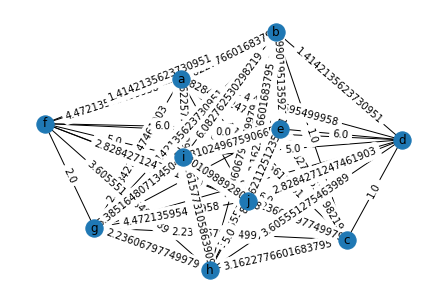

(26.514155011626464, [0, 7, 1, 2, 9, 5, 3, 8, 6, 4, 0])
(28.816740946526078, [0, 7, 1, 2, 3, 5, 8, 9, 6, 4, 0])
(26.6873039781939, [0, 4, 8, 3, 5, 2, 9, 1, 6, 7, 0])


In [128]:
euclideanGraph = generateInstance(10, euclideanDistance)

drawGraph(euclideanGraph)

print(branchAndBoundTSP(euclideanGraph))
print(twiceAroundTheTreeTSP(euclideanGraph))
print(christofidesTSP(euclideanGraph))

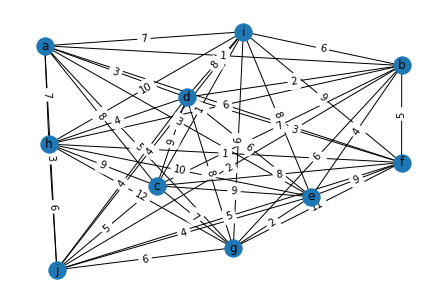

(30, [0, 1, 3, 5, 7, 9, 2, 8, 6, 4, 0])
(34, [0, 1, 3, 5, 7, 9, 8, 2, 4, 6, 0])
(32, [0, 4, 6, 2, 8, 9, 1, 7, 5, 3, 0])


In [129]:
manhattanGraph = generateInstance(10, manhattanDistance)

drawGraph(manhattanGraph)

print(branchAndBoundTSP(manhattanGraph))
print(twiceAroundTheTreeTSP(manhattanGraph))
print(christofidesTSP(manhattanGraph))